In [2]:
import os
from scipy.io import loadmat
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from concurrent.futures import ProcessPoolExecutor, as_completed
from mtcnn import MTCNN
import fcntl
import time
import shutil
import math
from collections import Counter
import mplcursors
import albumentations as A
import seaborn as sns
import random

os.environ["OPENCV_IO_ENABLE_OPENEXR"]="1"

# About

- Được cung cấp bởi TS.Ngô Thành Trung chứa dữ liệu của 453 người phục vụ cho bài toán Face Recognition (FR)
- Mỗi 1 người có thể có nhiều phiên chụp, mỗi phiên chụp là 1 subfolder trong folder id của người đó. Với mỗi phiên chụp ta có 4 ảnh được chụp dưới các điều kiện chiếu sáng khác nhau.
- Trong mỗi 1 folder phiên chụp chứa các file: 
    - Lightsource.m: là tọa độ đặt nguồn sáng tương ứng của 4 ảnh trong không gian Oxyz
    - metadata.txt: chứa tọa độ x và y của 11 đặc điểm khuôn mặt, bao gồm: khóe mắt ngoài bên trái, khóe mắt trong bên trái, điểm giữa trán, khóe mắt trong bên phải, khóe mắt ngoài bên phải, mũi bên trái, đỉnh mũi, mũi bên phải, khóe miệng bên trái, khóe miệng bên phải và cằm.
    - metadataII.txt: chứa thêm các thông tin: giới tính, kính mắt, râu (không có, có râu, có ria, cả hai, hay lún phún), tư thế (1 là chính diện - 5 là nghiêng), chất lượng (tốt, mờ, hoặc tối), chướng ngại (điện thoại di động, tay, tóc hoặc khác), biểu cảm (nhìn trống rỗng, tích cực, tiêu cực hoặc khác), và các thông tin khác (miệng mở hoặc mắt nhắm).

# Analysis and Understand Dataset

## Vấn đề 1: Dịch ảnh

Phương pháp photometric stereo có 1 nhược điểm: **các pixel của vật thể phải tương đương nhau trên mọi bức ảnh không được sai khác dù chỉ 1 pixel**. Vì chỉ cần người được chụp sai khác 1 pixel cũng sẽ dẫn đến việc tính toán sai normal map của vật thể tại pixel đó. Thông tin 3D trích xuất được của pixel bị sai sẽ làm model học sai hình dạng vật thể trong môi trường 3D. Mà thường không có chuyện sai 1 pixel mà là sai rất nhiều pixel.

Thực tế trong với mỗi phiên chụp của 1 người, người thu thập data đã cố gắng chụp ảnh nhanh 4 bức ảnh của người đó với các điều kiện ánh sáng khác nhau để có thể tận dụng được phương pháp photometric stereo trong tái tạo 3D. Tuy nhiên việc này chỉ mang tính chất tương đối vì đầu người có chuyển động nhẹ trong quá trình chụp dẫn đến sai lệch khoảng 20 pixel.

**Do đó việc đầu tiên trong quá trình xử lý ảnh là dịch các ảnh trong mỗi phiên chụp để đảm bảo khuôn mặt trong tất cả các ảnh khớp nhau.**

## Vấn đề 2: Tái tạo 3D bằng phương pháp Photometric stereo

Trong dataset được cung cấp có file generateSNAndZ_linux.p do người thu thập data cung cấp. File này sử dụng phương pháp photometric stereo để tạo ra các ảnh cung cấp thông tin 3D của khuôn mặt, bao gồm:
- albedo: hiệu suất chiếu sáng hiển thị màu sắc vật thể
- sn map: là px, py trong gradient space và có thêm đại lượng pz (tính bằng pytago của px và py)
- z.map: depth map của vật thể

Tạo tài khoản [MATLAB free](https://matlab.mathworks.com/), update dataset và các file file trên lên để MATLAB tính toán các file. 

*MATLAB driver chỉ có 5GB lưu trữ và 20 tiếng trong vòng 1 tháng với người dùng free. Do đó cần chia nhỏ dataset thành các batch, mỗi batch không quá 0.6GB. Code spilit, merge, caculator nằm trong folder /tmp*

In [ ]:
# Đường dẫn đến các file .mat
# dir_path = '../Photometric_DB/2220/2007-12-04_12-11-40'
# dir_path = '../Photometric_DB/2224/2007-12-07_10-33-33'
dir_path = '../Photometric_DB/1001/2008-03-27_16-25-37'
# dir_path = '../Photometric_DB/1002/2008-02-25_17-34-06'
# dir_path = '../Photometric_DB/1001/2009-07-09_13-25-40'

sn_path = os.path.join(dir_path, 'sn.mat')
z_path = os.path.join(dir_path, 'z.mat')
depthmap_path = os.path.join(dir_path, 'albedo.mat')

# Load dữ liệu từ các file .mat
sn_data = loadmat(sn_path)
z_data = loadmat(z_path)
albedo_data = loadmat(depthmap_path)

# Hiển thị các keys trong các file .mat
print(sn_data.keys())
print(z_data.keys())
print(albedo_data.keys())

In [ ]:
px = sn_data['px']
py = sn_data['py']
# Trong phương pháp photometric stereo chỉ có 2 thành phần px và py. Tuy nhiên từ đó ta hoàn toàn có thể tính được pz theo định lý pytago, pz trong dataset này là kết quả của điều này.
pz = sn_data['pz']

z = z_data['z']  # Độ sâu của mỗi điểm ảnh
albedo = albedo_data['a']  # Hiệu suất phản chiếu của mỗi điểm ảnh

In [ ]:
# print(px)
print(np.min(px))
print(np.max(px))
print(np.shape(px))
# Kết luận: px và py là ma trận 2 chiều bằng kích thước ảnh. Biểu diễn normal vector của vật thể trong không gian gradient. 
# Và nó đã được chuẩn hóa để kích thước là 1. Đặc biệt nó có thể âm

plt.figure(figsize=(12,8))

plt.subplot(1,2,1)
plt.imshow(px, cmap='gray') # Do px, py là ma trận 2 chiều và được chuẩn hóa trong đoạn [0,1] nên có thể hiển thị grayscale
plt.title('Pháp tuyến px')
plt.colorbar()
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(py, cmap='gray') # Do px, py là ma trận 2 chiều và được chuẩn hóa trong đoạn [0,1] nên có thể hiển thị grayscale
plt.title('Pháp tuyến py')
plt.colorbar()
plt.axis('off')

plt.show()
# Các giá trị px, py nằm trong khoảng [-1;1]

In [ ]:
pz_computed = np.sqrt(1 - (px**2 + py**2))

# So sánh với giá trị pz thực tế
if np.allclose(pz, pz_computed):
    print("pz tuân theo định lý Pythagoras từ px và py.")
else:
    print("pz không tuân theo định lý Pythagoras từ px và py.")

# Kết luận: Bản thân 1 vector trong hệ gradient space được biểu diễn bởi (px,py) và ánh xạ duy nhất đến 1 vector trong không gian Oxyz nên không cần có pz. pz được suy ra từ px và py, trong dataset họ tính thêm vào

plt.imshow(pz, cmap='gray')
plt.title('Pháp tuyến pz')
plt.colorbar()
plt.axis('off')
plt.show()

Tạo normal map từ các vector pháp tuyến thành phần: Để biểu diễn 1 vector trong hệ Oxyz, ta đã đưa nó về hệ tọa độ gradient space. Nơi chỉ phụ thuộc 2 thành phần duy nhất là px và py. Bây giờ ta đã biết được px, py và pz thì dễ dàng tìm lại được vector pháp tuyến của bề mặt.

![](images/Pháp%20tuyến.png)

In [ ]:
normal_map = cv2.merge([pz, -px, py])

# Chuẩn hóa các giá trị vector vào khoảng [0, 1] 
# Khi chuẩn hóa về [0, 1], dữ liệu sẽ phù hợp với nhiều mô hình học sâu hơn, đặc biệt là các mô hình CNN. 
#   Vì hầu hết các mô hình đều giả định input là ảnh RGB có giá trị trong khoảng [0,1] hoặc [0, 255]
#   Các hàm Relu sẽ hoạt động tốt hơn khi dữ liệu không có giá trị âm
#   Dễ dàng tích hợp với các pipeline xử lý ảnh tiêu chuẩn
# Giữ nguyên [-1,1]
#   Giữ lại thông tin normal map 1 cách chuẩn xác hơn, thậm chí trong quá trình check ảnh có thể nhìn ảnh đẹp/rõ ràng hơn. Nhưng tóm lại khi vào model nó vẫn là tensor.
#   Không thích hợp để fine-tunining mô hình đã được pre-trained. Vì đa số mặc định đầu vào khi train không có số dương,

normal_map = (normal_map + 1) / 2
normal_map = normal_map.astype(np.float32)

cv2.imwrite('./normalmap.exr', normal_map)

normal_map= cv2.imread('./normalmap.exr', cv2.IMREAD_UNCHANGED)

# pylot không hỗ trợ đọc ảnh exr mà mặc định nó đọc ảnh RGB. Do đó khi gặp các biến âm, matplotlib tự động bỏ hoặc làm gì đó.
# Do đó visualize ảnh exr thường không cho cái nhìn chính xác mà ta phải cài tool và đọc ảnh bên ngoài.
plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(normal_map, cv2.COLOR_BGR2RGB))
plt.title('Normal Map')
plt.colorbar()
plt.axis('off')

img0_path = os.path.join(dir_path, 'im0.bmp')
img0 = cv2.imread(img0_path)

# print(np.min(img0))
# print(np.max(img0))
# print(np.max(normal_map))
# print(np.min(normal_map))

plt.subplot(1,2,2)
plt.imshow(cv2.cvtColor(img0, cv2.COLOR_BGR2RGB))
plt.axis('off') # Tắt trục tọa độ
plt.title('Image 0')
plt.colorbar()

plt.show()

Tại sao lại lưu ảnh dưới dạng exr ?
- Deepmap trong photometric stereo là 1 bản đồ mô tả độ sâu của vật thể . Nó là 1 ma trận 2 chiều và giá trị các phần tử là số thực có thể âm và không có min và max xác định, tùy thuộc vào điểm mà bạn chọn làm mốc tính độ sâu.
- png: lưu giá trị dưới dạng số nguyên 8 bit (0-255). Điều này có nghĩa nếu dùng nó để lưu depth map thì các giá trị pixel của ảnh sẽ được normalize. Điều này làm sai lệch ý nghĩa độ sâu của ảnh.
- jpg: cũng lưu trữ ảnh dưới dạng số nguyên. Nhưng nó còn nèn ảnh, nó sử dụng kernel có kích thước 8*8 và chuyển đổi ảnh sang không gian màu YcbCr, ... => Mặc dù ảnh nhẹ hơn PNG nhưng độ chính xác của ảnh, thông tin 3D mà ảnh mang lại còn bị giảm mạnh hơn so với ảnh PNG
- exr: lưu hình ảnh ở dạng số thực. Phù hợp để lưu trữ depth map. Định dạng này không convert hay chuẩn hóa gì cả nên cung cấp thông tin chính xác hơn về độ sâu của vật thể. Được sử dụng rất nhiều trong các ứng dụng sản xuất chuyên nghiệp và độ họa 3D.

Lưu ý khi làm việc với ảnh ở định dạng exr:
- opencv mặc định tắt khả năng lưu numpy ở dạng exr, cần bật nó lên và convert dtype của numpy về float32 thì mới save được.
```sh
os.environ["OPENCV_IO_ENABLE_OPENEXR"]="1"
normal_map = normal_map.astype(np.float32)
```
- opencv mặc định sẽ convert ảnh về BRG space nên cần tắt nó đi khi đọc ảnh exr
```sh
img = cv2.imread('path_to_your_file.exr', cv2.IMREAD_UNCHANGED)
```
- opencv và matplot không hỗ trợ show ảnh exr. Muốn nhìn chính xác normal phải cài phần mềm thứ 3 về mới nhìn được, hình mà matplot lib show ra ở trên là sai. Trong Ubuntu phần mềm phổ biến nhất là DIV.

In [1]:
# print(z)
# print(np.min(z))
# print(np.max(z))
# print(np.shape(z))
# Kết luận: Deepth map Z là ma trận 2 chiều có shape bằng size của ảnh. Giá trị nhỏ nhất của deepth map là 0, nghĩa là mốc được chọn làm mốc để tính tích phân là pixel có độ sâu thấp nhất.
cv2.imwrite('./albedo.exr', z.astype(np.float32))

dep = cv2.imread('./albedo.exr', cv2.IMREAD_UNCHANGED)

print(np.min(dep))
print(np.max(dep))
print(np.shape(dep))

plt.imshow(dep, cmap='gray')
plt.title('Depth map')
plt.axis('off')

plt.show()

NameError: name 'cv2' is not defined

In [ ]:
# print(albedo)

print(np.min(albedo))
print(np.max(albedo))
print(np.shape(albedo))

# Kết luận: albedo là 1 ma trận 2 chiều đã được hiệu chỉnh về [0, 255]. Đây là ảnh mà không bị phụ thuộc bởi nguồn sáng"

cv2.imwrite('./albedo.exr', albedo.astype(np.float32))

albedo = cv2.imread('./albedo.exr', cv2.IMREAD_UNCHANGED)

print(np.min(albedo))
print(np.max(albedo))
print(np.shape(albedo))

plt.imshow(albedo, cmap='gray')
plt.title('albedo gray')
plt.axis('off')
plt.colorbar()
plt.show()

In [ ]:
im0 = cv2.imread(os.path.join(dir_path, 'im0.bmp'))

cv2.imwrite('im0.bmp', im0)

im0_saved = cv2.imread('im0.bmp')

plt.subplot(1,2,1)
plt.axis('off')
plt.title('Origin Image')
plt.imshow(cv2.cvtColor(im0, cv2.COLOR_BGR2RGB))

plt.subplot(1,2,2)
plt.axis('off')
plt.title('Saved Image')
plt.imshow(cv2.cvtColor(im0_saved, cv2.COLOR_BGR2RGB))

plt.show()

# Preprocess dataset

Các đoạn code dưới đây thực hiện trên CPU, hãy thay đổi số CPU sao cho phù hợp với máy của bạn, hiển nhiên càng nhiều càng nhanh :v

## 0. Rollback dataset to origin

Thay đổi đường dẫn đến dataset và số lượng cpu sao cho nó phù hợp với máy

In [52]:
photometric_db = './tmp/Photometric_DB'

num_cpus = 14

files_to_keep = [
    'im0.bmp', 'im1.bmp', 'im2.bmp', 'im3.bmp', 
    'LightSource.m', 'metadata.txt', 'metadatall.txt', 
    'albedo.mat', 'z.mat', 'sn.mat',
    'albedo.exr', 'normalmap.exr', 'depthmap.exr'
]

In [45]:
import os
from concurrent.futures import ProcessPoolExecutor

def delete_unwanted_files(seesion_path):
    for filename in os.listdir(seesion_path):
        if filename not in files_to_keep:
            file_path = os.path.join(seesion_path, filename)
            os.remove(file_path)
            
def process_each_session(id_path):
    for session in os.listdir(id_path):
        seesion_path = os.path.join(id_path, session)
        if os.path.isdir(seesion_path):
            delete_unwanted_files(seesion_path)

def rollback_dataset(num_cpus):
    with ProcessPoolExecutor(max_workers=num_cpus) as executor:
        for id in os.listdir(photometric_db):
            id_path = os.path.join(photometric_db, id)
            if os.path.isdir(id_path):
                # Gửi các tác vụ để xử lý song song
                executor.submit(process_each_session, id_path)

rollback_dataset(num_cpus)

## 1. Generate normalmap.exr, albedo.exr, depthmap.exr to dataset folder

In [3]:
photometric_db = '../Photometric_DB'

num_cpus = 14

In [4]:
# Chứa các file nếu xử lý bị lỗi
error_file = 'error_people.txt'

def create_3d_images(session_path, id_dir):
    sn_path = os.path.join(session_path, 'sn.mat')
    z_path = os.path.join(session_path, 'z.mat')
    albedo_path = os.path.join(session_path, 'albedo.mat')
    
    error_messages = []

    if os.path.exists(sn_path) and os.path.exists(z_path) and os.path.exists(albedo_path):
        try:
            # Load dữ liệu từ các file .mat
            sn_data = loadmat(sn_path)
            z_data = loadmat(z_path)
            albedo_data = loadmat(albedo_path)
            
            # Trích xuất các thông tin cần thiết từ mat file
            px = sn_data['px']
            py = sn_data['py']
            pz = sn_data['pz']
            z = z_data['z']
            albedo = albedo_data['a']
            
            # Save các ảnh normal map
            try:
                normal_map = cv2.merge([pz, -px, py])
                normal_map = (normal_map + 1)/2
                normal_map = normal_map.astype(np.float32)
                normal_map_path = os.path.join(session_path, 'normalmap.exr')
                cv2.imwrite(normal_map_path, normal_map)
            except Exception as e:
                error_messages.append(f"{id_dir}: Error saving normal map: {repr(e)}")

            # Save các ảnh depth map
            try:
                z = z/255
                depth_map = z.astype(np.float32())
                depth_map_path = os.path.join(session_path, 'depthmap.exr')
                cv2.imwrite(depth_map_path, depth_map)
            except Exception as e:
                error_messages.append(f"{id_dir}: Error saving depth map: {repr(e)}")

            # Save các ảnh albedo map
            try:
                albedo = albedo / 255
                albedo_map = albedo.astype(np.float32())
                albedo_map_path = os.path.join(session_path, 'albedo.exr')
                cv2.imwrite(albedo_map_path, albedo_map)
            except Exception as e:
                error_messages.append(f"{id_dir}: Error saving albedo map: {repr(e)}")

            if error_messages:
                return "\n".join(error_messages)
            return None

        except Exception as e:
            return f"{id_dir}: Error loading .mat files: {repr(e)}"
    else:
        return f"{id_dir}: Missing files"

with ProcessPoolExecutor(max_workers=num_cpus) as executor:
    for people_dir in os.listdir(photometric_db):
        people_path = os.path.join(photometric_db, people_dir)
        if os.path.isdir(people_path):
            for session in os.listdir(people_path):
                session_path = os.path.join(people_path, session)
                executor.submit(create_3d_images, session_path, people_dir)

KeyboardInterrupt: 

In [ ]:
session = '../Photometric_DB/1050/2008-02-28_14-58-14'

normalmap_path = '../3D_Dataset/Normal_Map/1001/2008-02-23_12-21-31.exr'
# depthmap_path = os.path.join(session, 'depthmap.exr')
# albedo_path = os.path.join(session, 'albedo.exr')

# Load ma trân ảnh về RGB color space
normal_map = cv2.imread(normalmap_path, cv2.IMREAD_UNCHANGED)
# depth_map = cv2.imread(depthmap_path, cv2.IMREAD_UNCHANGED)
# albedo = cv2.imread(albedo_path, cv2.IMREAD_UNCHANGED)

print(normal_map.shape)
# print(depth_map.shape)
# print(albedo.shape)

# plt.figure(figsize=(15,5))

# plt.subplot(1,3,1)
plt.imshow(cv2.cvtColor(normal_map, cv2.COLOR_BGR2RGB))
plt.title('Normal map')
plt.colorbar()
plt.axis('off')

# plt.subplot(1,3,2)
# plt.imshow(depth_map, cmap='gray')
# plt.title('Depth map')
# plt.colorbar()
# plt.axis('off')

# plt.subplot(1,3,3)
# plt.imshow(albedo, cmap='gray')
# plt.title('Albedo')
# plt.colorbar()
# plt.axis('off')

plt.show()

## 2. Face Detection

### Lý thuyết

![](images/FR%20pipeline.png)

[Research](https://arxiv.org/abs/2212.13038) là 1 cuộc khảo sát tổng quát về các công nghệ nổi bật được thực hiện trong lĩnh vực Face Recognition.
Hình trên là kiến trúc tổng quát của 1 hệ thống FR, được trích xuất từ research. Theo như research, bước preprocesssing trước khi train model gồm có 2 bước Face detection và Face alignment
- Face detection: research giới thiệu tổng quát các phương pháp face detect đã từng được sử dụng trong nhiều trường hợp như khuôn mặt bị che khuất, khuôn mặt nhỏ, ánh sáng yếu, ... Với sự phát triển của kỹ thuật nhận diện đối tượng 2D, face detection cũng theo đó mà phát triển và đạt hiệu cao trong các kịch bản thực tế. Do đó các nghiên cứu liên quan đến face detection ngày càng ít xuất hiện trong những năm gần đây.
- Face Alignments: sau khi trải qua bước Face detect, ảnh thu được thường có shape khác nhau. Điều này là do góc chụp cũng như tư thế chụp ảnh gây ra và có thể gây ảnh hưởng mạnh đến hiệu suất của model. Face alignments là cách căn chỉnh khuôn mặt về 1 góc nhìn duy nhất giúp giảm thiểu sự ảnh hưởng của góc/tư thế chụp đến hiệu suất của model. Tuy nhiên khi các training set phục vụ hệ thống FR trở lên lớn hơn, đa dạng hơn, 1 số phương pháp FR chọn bỏ qua bước Face Aligments và trực tiếp train và test face patches thu được từ quá trình face detection. Về mặt kỹ thuật, Face Alignments là 1 cách để tăng tính intra-class (đồng nhất) trong cùng 1 class tức các đặc trưng trong dataset của 1 người trở nên tương đồng hơn, dễ phân loại hơn.

Đối với dataset này
- Face detection: các khuôn mặt được chụp trong các môi trường ánh sáng đa dạng, không bị che khuất. Do đó ở bước này, em sử dụng mạng mtcnn được giới thiệu đã được pre-trained để detect face.
- Face alignments: các khuôn mặt trong dataset được chụp với tư thế chính diện để phục vụ kỹ thuật photometric stereo do đó em thấy bước này trong dataset gần như không mang lại sự cải thiện về mặt hiệu suất nên em quyết định bỏ qua.

Mã nguồn mtcnn: https://github.com/ipazc/mtcnn

Kiến trúc mtcnn: Sử dụng 3 networks để detect vị trí của face trong images và các đặc điểm của khuôn mặt (face landmarks)
- PNet (Proposal Network): 
    - Là 1 mạng CNN nhỏ, scan image bằng các kernel có kích thước khác nhau. 
    - Ở mỗi cửa sổ, P-Net xác định xem có khả năng khuôn mặt không, đồng thời xác định vị trí khung giới hạn (bounding box) và các điểm đặc trưng trên khuôn mặt (landmarks). 
    - Các bounding box khi mới được hình thành thường có xu hướng duplicate và chồng lên nhau. Thuật toán Non-Maximum Suppression (NMS) được sử dụng để loại bỏ các vùng trùng lặp và chọn ra bounding box tốt nhất.
- RNet (Refine Network): 
    - Nhận diện và tinh chỉnh các bounding box do PNet đề xuất để cải thiện độ chính xác của chúng. 
    - NMS cũng được sử dụng trong giai đoạn này để loại bỏ các khung trùng lặp và giữ lại các khung có độ tin cậy cao hơn.
- ONet (Output Network):
    - Nhận các bounding box đã được tinh chỉnh từ RNet và thực hiện tinh chỉnh lần cuối cùng.
    - Mạng detect chính xác bounding box và face landmarks trong image và trả về kết quả.

Kiến trúc MTCNN thường được ứng dụng rộng rãi trong các hệ thống nhận diện khuôn mặt nhờ tính hiệu quả và độ chính xác cao khi phát hiện khuôn mặt trong thời gian thực.

### Test mtcnn

In [5]:
message = '../Photometric_DB/2132/2008-05-30_10-53-56'

img0_path = os.path.join(message, 'im0.bmp')
normalmap_path = os.path.join(message, 'normalmap.exr')
depthmap_path = os.path.join(message, 'depthmap.exr')
albedo_path = os.path.join(message, 'albedo.exr')

img0 = cv2.imread(img0_path)
normal_map = cv2.imread(normalmap_path, cv2.IMREAD_UNCHANGED)
depth_map = cv2.imread(depthmap_path, cv2.IMREAD_UNCHANGED)
albedo = cv2.imread(albedo_path, cv2.IMREAD_UNCHANGED)

plt.subplot(1,4,1)
plt.title('Image 0')
plt.imshow(cv2.cvtColor(img0, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(1,4,2)
plt.title('Albedo')
plt.imshow(albedo, cmap='gray')
plt.axis('off')

plt.subplot(1,4,3)
plt.title('Normal map')
plt.imshow(cv2.cvtColor(normal_map, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(1,4,4)
plt.title('Depth Map')
plt.imshow(depth_map, cmap='gray')
plt.axis('off')

plt.show()

NameError: name 'cv2' is not defined

In [ ]:
plt.subplot(1,3,1)
plt.imshow(albedo, cmap='gray')
plt.title('Origin')
plt.axis('off')

# Create a detector instance
detector = MTCNN(device="CPU:5")

# Detect faces in the bmp image
bmp_result = detector.detect_faces(img0)

# Display the result
print(bmp_result)

# Detect faces in the albedo image
albedo_result = detector.detect_faces(cv2.cvtColor(albedo, cv2.COLOR_GRAY2RGB))

# Display the result
print(albedo_result)

x, y, width, height = albedo_result[0]['box']

face_crop = albedo[y:y + height, x:x + width]
plt.subplot(1,3,2)
plt.imshow(face_crop, cmap='gray')
plt.title('Crop')
plt.axis('off')

center_x = x + width // 2
center_y = y + height // 2

width = int(width + 0.3 * width)
height = int(height + 0.3 * height)

# Tính toán các giá trị x, y mới sao cho center không đổi
x = max(int(center_x - width // 2), 0)
y = max(int(center_y - height // 2), 0)

face_crop = albedo[y:y + height, x:x + width]
plt.subplot(1,3,3)
plt.imshow(face_crop, cmap='gray')
plt.title('Resize')
plt.axis('off')

plt.show()

### Apply to dataset

#### Run mtcnn to auto face aligment

In [36]:
photometric_db = '../Photometric_DB'

num_cpus = 10

Crop chính diện khuôn mặt các image có size (336, 448)

Các phương pháp nội suy. Nội suy (interpolation) được sử dụng để ước lượng giá trị của điểm ảnh mới dựa trên các điểm ảnh xung quanh. Việc chọn phương pháp nội suy phù hợp phụ thuộc vào loại ảnh và mục đích xử lý

![](images/Inter_linear.png)

![](images/inter_nearest.png)

![](images/inter_area.png)

In [37]:
def log_to_file(filename, message):
    with open(filename, 'a') as file:
        fcntl.flock(file, fcntl.LOCK_EX)
        try:
            file.write(message + '\n')
        finally:
            fcntl.flock(file, fcntl.LOCK_UN)
            
def adjust_box(box, shape):
    x, y, width, height = box
    center_x = x + width // 2
    center_y = y + height // 2

    im_size = int(height * 2)
    
    new_x = center_x - int(im_size//2)
    new_y = center_y - int(im_size//2)
    
    if new_x < 0:
        im_size = im_size - abs(new_x) * 2
        new_y = new_y + abs(new_x)
        new_x = 0
        
    if new_y < 0:
        im_size = im_size - abs(new_y) * 2
        new_x = new_x + abs(new_y)
        new_y = 0
    
    image_height, image_width = shape[:2]
    
    tmp_width = new_x + im_size - image_width
    if tmp_width > 0:
        im_size = im_size - tmp_width * 2
        new_y += tmp_width
        new_x += tmp_width
     
    tmp_height = new_y + im_size - image_height
    if tmp_height > 0:
        im_size = im_size - tmp_height * 2
        new_x += tmp_height
        new_y += tmp_height

    adjusted_box = [new_x, new_y, im_size, im_size]

    return adjusted_box


def crop_image(image, box, image_path):
    x, y, width, height = box

    face_crop = image[y:y + height, x:x + width]

    # Tạo tên file mới với hậu tố '_crop' trong cùng thư mục
    base, ext = os.path.splitext(image_path)
    new_image_path = f"{base}_crop{ext}"

    # Lưu ảnh đã cắt
    if ext.lower() == '.bmp':
        cv2.imwrite(new_image_path, face_crop)
    elif ext.lower() == '.exr':
        cv2.imwrite(new_image_path, face_crop.astype(np.float32))

def detect_face_in_all_bmp(session_path, detector, global_box, global_image_path):
    if global_box is None:
        box = None
        retry_images = []
        bmp_images = [
            os.path.join(session_path, 'im0.bmp'),
            os.path.join(session_path, 'im1.bmp'),
            os.path.join(session_path, 'im2.bmp'),
            os.path.join(session_path, 'im3.bmp')
        ]
        for image_path in bmp_images:
            image = cv2.imread(image_path)
            result = detector.detect_faces(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
            if len(result) == 1 :
                if result[0]['confidence'] >= 0.9:
                    box = adjust_box(result[0]['box'], image.shape)
                    crop_image(image, box, image_path)
                else:
                    retry_images.append(image_path)
            elif len(result) >=2:
                max_confidence_index = max(
                    (i for i, res in enumerate(result) if 'confidence' in res and res['confidence'] >= 0.9),
                    key=lambda i: result[i]['confidence'],
                    default=None
                )

                max_confidence_box = result[max_confidence_index]['box'] if max_confidence_index is not None else None
                
                if max_confidence_box:
                    box = adjust_box(max_confidence_box, image.shape)
                    crop_image(image, box, image_path)
                else:
                    retry_images.append(image_path)
            else:
                retry_images.append(image_path)
        return box, retry_images                
    else:
        image = cv2.imread(global_image_path)
        box = adjust_box(global_box, image.shape)
        crop_image(image, box, global_image_path)
    
def detect_face_in_all_exr(session_path, detector, global_box):
    normalmap_path = os.path.join(session_path, 'normalmap.exr')
    albedo_path = os.path.join(session_path, 'albedo.exr')
    depthmap_path = os.path.join(session_path, 'depthmap.exr')
    
    normal_map = cv2.imread(normalmap_path, cv2.IMREAD_UNCHANGED)
    albedo = cv2.imread(albedo_path, cv2.IMREAD_UNCHANGED)
    depth_map = cv2.imread(depthmap_path, cv2.IMREAD_UNCHANGED)
    
    if global_box is None:
        box = None
        retry_images = []
        result = detector.detect_faces(cv2.cvtColor(albedo*255, cv2.COLOR_GRAY2RGB))
        if len(result) == 1:
            if result[0]['confidence'] >= 0.9:
                box = adjust_box(result[0]['box'], albedo.shape)
                crop_image(normal_map, box, normalmap_path)
                crop_image(albedo, box, albedo_path)
                crop_image(depth_map, box, depthmap_path)
            else:
                retry_images.append(albedo_path)
        elif len(result) >=2:
            # Tìm index của phần tử có confidence cao nhất (>= 0.99)
            max_confidence_index = max(
                (i for i, res in enumerate(result) if 'confidence' in res and res['confidence'] >= 0.9),
                key=lambda i: result[i]['confidence'],
                default=None
            )
            max_confidence_box = result[max_confidence_index]['box'] if max_confidence_index is not None else None
            
            if max_confidence_box:
                box = adjust_box(max_confidence_box, albedo.shape)
                crop_image(normal_map, box, normalmap_path)
                crop_image(albedo, box, albedo_path)
                crop_image(depth_map, box, depthmap_path)
            else:
                retry_images.append(albedo_path)
        else:
            retry_images.append(albedo_path)
        return box, retry_images
    else:
        box = adjust_box(global_box, albedo.shape)
        crop_image(normal_map, box, normalmap_path)
        crop_image(albedo, box, albedo_path)
        crop_image(depth_map, box, depthmap_path)
        
def process_session(session_path, cpu_index):
    try:
        global_box = None
        global_retry_images = []

        # Khởi tạo detector cho CPU cụ thể
        detector = MTCNN(device=f"CPU:{cpu_index}")

        # Gọi hàm detect cho từng định dạng
        bmp_box, bmp_retry_images = detect_face_in_all_bmp(session_path, detector, None, None)
        exr_box, exr_retry_images = detect_face_in_all_exr(session_path, detector, None)

        # Xác định global_box và global_retry_images
        global_box = exr_box if exr_box else bmp_box
        global_retry_images.extend(bmp_retry_images)
        global_retry_images.extend(exr_retry_images)

        # Xử lý các ảnh cần retry
        if global_retry_images:
            if global_box:
                for image_path in global_retry_images:
                    _, ext = os.path.splitext(image_path)
                    if ext == '.bmp':
                        detect_face_in_all_bmp(None, None, global_box, image_path)
                    elif ext == '.exr':
                        detect_face_in_all_exr(session_path, None, global_box)
            else:
                log_to_file('failed_crop.txt', session_path)
                print(f"Không detect được face trong session {session_path}.")
    except Exception as e:
        log_to_file('session_exception.txt', session_path)
        raise
    finally:
        log_to_file('processed_sessions.txt', session_path)  # Ghi lại session đã xử lý

cpu_index = 0
count = 1

# Đọc các session đã xử lý từ file checkpoint (nếu có)
processed_sessions = set()
if os.path.exists('processed_sessions.txt'):
    with open('processed_sessions.txt', 'r') as f:
        processed_sessions = set(f.read().splitlines())

# Thu thập tất cả session_path chưa được xử lý
session_paths_to_process = []
for id in os.listdir(photometric_db):
    id_path = os.path.join(photometric_db, id)
    if os.path.isdir(id_path):
        for session in os.listdir(id_path):
            session_path = os.path.join(id_path, session)
            # Chỉ thêm các session chưa xử lý vào danh sách
            if session_path not in processed_sessions:
                session_paths_to_process.append(session_path)

with ProcessPoolExecutor(max_workers=num_cpus) as executor:
    for session_path in session_paths_to_process:
        if count % 100 == 0:
            time.sleep(30)
        
        executor.submit(process_session, session_path, cpu_index)
        cpu_index = cpu_index % num_cpus
        cpu_index += 1
        count += 1

In [ ]:
session = '../Photometric_DB/2156/2008-02-18_15-34-44'

im0 = cv2.cvtColor(cv2.imread(os.path.join(session, 'im0_crop.bmp')), cv2.COLOR_BGR2RGB)
im1 = cv2.cvtColor(cv2.imread(os.path.join(session, 'im1_crop.bmp')), cv2.COLOR_BGR2RGB)
im2 = cv2.cvtColor(cv2.imread(os.path.join(session, 'im2_crop.bmp')), cv2.COLOR_BGR2RGB)
im3 = cv2.cvtColor(cv2.imread(os.path.join(session, 'im3_crop.bmp')), cv2.COLOR_BGR2RGB)
normal_map = cv2.imread(os.path.join(session, 'normalmap_crop.exr'), cv2.IMREAD_UNCHANGED)
albedo = cv2.imread(os.path.join(session, 'albedo_crop.exr'), cv2.IMREAD_UNCHANGED)
depth_map = cv2.imread(os.path.join(session, 'depthmap_crop.exr'), cv2.IMREAD_UNCHANGED)

plt.figure(figsize=(12,6))

plt.subplot(2,4,1)
plt.imshow(im0)
plt.axis('off')

plt.subplot(2,4,2)
plt.imshow(im1)
plt.axis('off')

plt.subplot(2,4,3)
plt.imshow(im2)
plt.axis('off')

plt.subplot(2,4,4)
plt.imshow(im3)
plt.axis('off')

plt.subplot(2,4,5)
plt.imshow(cv2.cvtColor(normal_map, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(2,4,6)
plt.imshow(depth_map, cmap='gray')
plt.axis('off')

plt.subplot(2,4,7)
plt.imshow(albedo, cmap='gray')
plt.axis('off')

plt.show()

#### Handle face aligment

Sau bước crop trên và kiểm tra ảnh, có 3/3159 session mà mtcnn không thể detect được. Thực hiện crop lại bằng tay.
- ../Photometric_DB/2013/2008-02-15_18-35-04
- ../Photometric_DB/2023/2008-04-24_17-10-16
- ../Photometric_DB/2060/2008-02-21_16-56-43

Detect lỗi
- ../Photometric_DB/1205/2008-12-16_14-30-03

In [18]:
def adjust_box(box, shape):
    x, y, width, height = box
    center_x = x + width // 2
    center_y = y + height // 2

    im_size = int(height * 2)
    
    new_x = center_x - int(im_size//2)
    new_y = center_y - int(im_size//2)
    
    if new_x < 0:
        im_size = im_size - abs(new_x) * 2
        new_y = new_y + abs(new_x)
        new_x = 0
        
    if new_y < 0:
        im_size = im_size - abs(new_y) * 2
        new_x = new_x + abs(new_y)
        new_y = 0
    
    image_height, image_width = shape[:2]
    
    tmp_width = new_x + im_size - image_width
    if tmp_width > 0:
        im_size = im_size - tmp_width * 2
        new_y += tmp_width
        new_x += tmp_width
     
    tmp_height = new_y + im_size - image_height
    if tmp_height > 0:
        im_size = im_size - tmp_height * 2
        new_x += tmp_height
        new_y += tmp_height

    adjusted_box = [new_x, new_y, im_size, im_size]

    return adjusted_box


def crop_image(image, box, image_path):
    x, y, width, height = box

    face_crop = image[y:y + height, x:x + width]

    # Tạo tên file mới với hậu tố '_crop' trong cùng thư mục
    base, ext = os.path.splitext(image_path)
    new_image_path = f"{base}_crop{ext}"

    # Lưu ảnh đã cắt
    if ext.lower() == '.bmp':
        cv2.imwrite(new_image_path, face_crop)
    elif ext.lower() == '.exr':
        cv2.imwrite(new_image_path, face_crop.astype(np.float32))

(1024, 1280, 3)


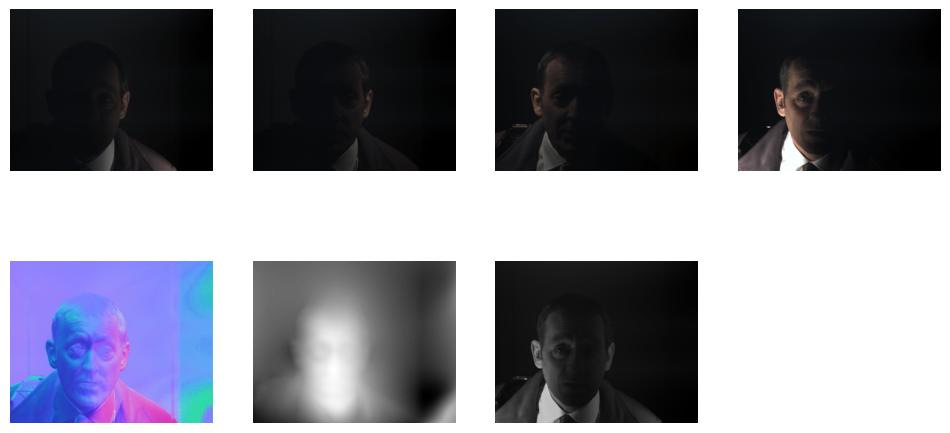

In [19]:
id_dir = '../Photometric_DB/2060/2008-02-21_16-56-43'

im0 = cv2.imread(os.path.join(id_dir, 'im0.bmp'))
im1 = cv2.imread(os.path.join(id_dir, 'im1.bmp'))
im2 = cv2.imread(os.path.join(id_dir, 'im2.bmp'))
im3 = cv2.imread(os.path.join(id_dir, 'im3.bmp'))
normal_map = cv2.imread(os.path.join(id_dir, 'normalmap.exr'), cv2.IMREAD_UNCHANGED)
albedo = cv2.imread(os.path.join(id_dir, 'albedo.exr'), cv2.IMREAD_UNCHANGED)
depth_map = cv2.imread(os.path.join(id_dir, 'depthmap.exr'), cv2.IMREAD_UNCHANGED)
print(im0.shape)
plt.figure(figsize=(12,6))

plt.subplot(2,4,1)
plt.imshow(cv2.cvtColor(im0, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(2,4,2)
plt.imshow(cv2.cvtColor(im1, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(2,4,3)
plt.imshow(cv2.cvtColor(im2, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(2,4,4)
plt.imshow(cv2.cvtColor(im3, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(2,4,5)
plt.imshow(cv2.cvtColor(normal_map, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(2,4,6)
plt.imshow(depth_map, cmap='gray')
plt.axis('off')

plt.subplot(2,4,7)
plt.imshow(albedo, cmap='gray')
plt.axis('off')

plt.show()

- '../Photometric_DB/2013/2008-02-15_18-35-04'

    box = [750,280,400,480]

    x, y, width, height = adjust_box(box, albedo.shape)
- '../Photometric_DB/2023/2008-04-24_17-10-16'

    box = [430, 0, 300,350]
    x, y, width, height = adjust_box(box, albedo.shape)
- '../Photometric_DB/1205/2008-12-16_14-30-03'

    box = [500, 550, 300, 380]

- '../Photometric_DB/2060/2008-02-21_16-56-43'
    box = [450, 400, 100, 350]

(-0.5, 699.5, 699.5, -0.5)

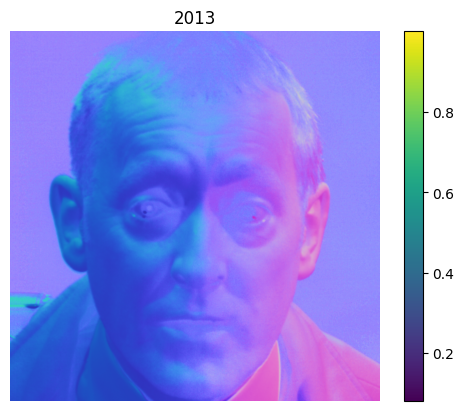

In [30]:
box = [450, 400, 100, 350]

x, y, width, height = adjust_box(box, albedo.shape)

# Cắt ảnh theo tọa độ bounding box
face_crop = normal_map[y:y + height, x:x + width]
plt.imshow(cv2.cvtColor(face_crop, cv2.COLOR_BGR2RGB))
plt.title('2013')
plt.colorbar()
plt.axis('off')

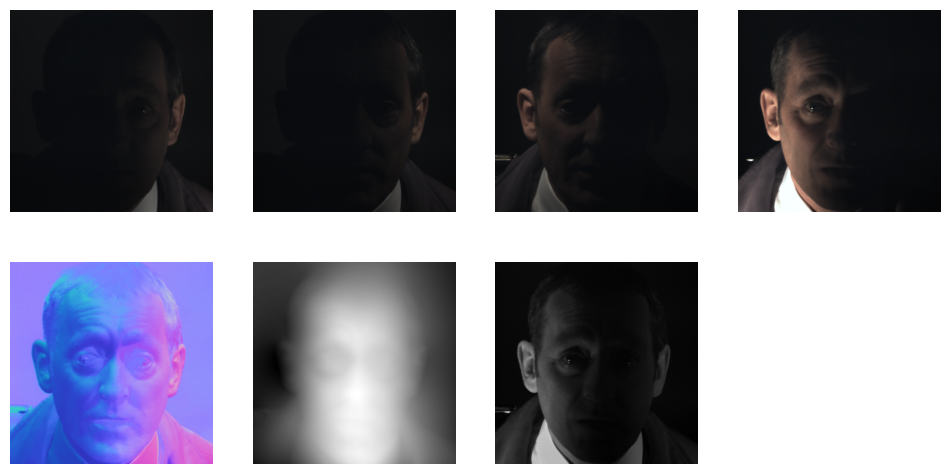

In [31]:
box = [450, 400, 100, 350]

session_path = '../Photometric_DB/2060/2008-02-21_16-56-43'

file_to_crop = ['im0.bmp', 'im1.bmp', 'im2.bmp', 'im3.bmp', 'normalmap.exr', 'albedo.exr', 'depthmap.exr']

for img in os.listdir(session_path):
    if img in file_to_crop:
        img_path = os.path.join(session_path, img)
        filename, ext = os.path.splitext(img)
        crop_image(cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB), adjust_box(box, albedo.shape), img_path)
        crop_image(cv2.imread(img_path, cv2.IMREAD_UNCHANGED), adjust_box(box, albedo.shape), img_path)
            
im0 = cv2.cvtColor(cv2.imread(os.path.join(session_path, 'im0_crop.bmp')), cv2.COLOR_BGR2RGB)
im1 = cv2.cvtColor(cv2.imread(os.path.join(session_path, 'im1_crop.bmp')), cv2.COLOR_BGR2RGB)
im2 = cv2.cvtColor(cv2.imread(os.path.join(session_path, 'im2_crop.bmp')), cv2.COLOR_BGR2RGB)
im3 = cv2.cvtColor(cv2.imread(os.path.join(session_path, 'im3_crop.bmp')), cv2.COLOR_BGR2RGB)
normal_map = cv2.imread(os.path.join(session_path, 'normalmap_crop.exr'), cv2.IMREAD_UNCHANGED)
albedo = cv2.imread(os.path.join(session_path, 'albedo_crop.exr'), cv2.IMREAD_UNCHANGED)
depth_map = cv2.imread(os.path.join(session_path, 'depthmap_crop.exr'), cv2.IMREAD_UNCHANGED)

plt.figure(figsize=(12,6))

plt.subplot(2,4,1)
plt.imshow(im0)
plt.axis('off')

plt.subplot(2,4,2)
plt.imshow(im1)
plt.axis('off')

plt.subplot(2,4,3)
plt.imshow(im2)
plt.axis('off')

plt.subplot(2,4,4)
plt.imshow(im3)
plt.axis('off')

plt.subplot(2,4,5)
plt.imshow(cv2.cvtColor(normal_map, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(2,4,6)
plt.imshow(depth_map, cmap='gray')
plt.axis('off')

plt.subplot(2,4,7)
plt.imshow(albedo, cmap='gray')
plt.axis('off')

plt.show()

## 3. Copy các file trong thư mục dataset vào 1 thư mục dataset mới

In [32]:
photometric_db = '../Photometric_DB'

dest_folder = '../3D_Dataset/Albedo'

files_to_copy = [
    'albedo_crop.exr'
]
num_cpus = 14

In [33]:
# Hàm sao chép file
def copy_file(filename, session_path, new_id_folder_path, session):
    source_file = os.path.join(session_path, filename)
    _, ext = os.path.splitext(filename)
    destination_file = os.path.join(new_id_folder_path, f"{session}{ext}")
    shutil.copy(source_file, destination_file)

# Tạo thư mục đích nếu chưa tồn tại
if not os.path.exists(dest_folder):
    os.makedirs(dest_folder, exist_ok=True)

# Sử dụng ProcessPoolExecutor để sao chép file từ các session path hợp lệ
with ProcessPoolExecutor() as executor:
    futures = []
    
    for id in os.listdir(photometric_db):
        id_path = os.path.join(photometric_db, id)
        if os.path.isdir(id_path):
            new_id_folder_path = os.path.join(dest_folder, id)
            if not os.path.exists(new_id_folder_path):
                os.mkdir(new_id_folder_path)
            
            for session in os.listdir(id_path):
                session_path = os.path.join(id_path, session)
                futures.append(executor.submit(copy_file, files_to_copy[0], session_path, new_id_folder_path, session))

    # Đợi tất cả các tác vụ sao chép hoàn thành
    for future in as_completed(futures):
        future.result()

FileNotFoundError: [Errno 2] No such file or directory: '../Photometric_DB/1042/2008-02-20_17-12-30/albedo_crop.exr'

## 4. Final check

### Check Face aligment

Kiểm tra lại lần cuối tất cả các ảnh, không có gì đảm MTCNN detect sai

In [ ]:
dest_folder = '../Dataset/Normal_Map/train'

id = 1001

In [ ]:
id_dir = os.path.join(dest_folder, str(id))
number_images = len(os.listdir(id_dir))

if number_images !=1:
    # Sử dụng math.ceil() để làm tròn số hàng
    row = math.ceil(number_images / 6)
    id = 1  # Chỉnh index bắt đầu từ 1 để tránh lỗi với plt.subplot()

    plt.figure(figsize=(18, row * 5))
    
    for image_name in os.listdir(id_dir):
        image_path = os.path.join(id_dir, image_name)
        image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
        plt.subplot(row, 6, id)
        plt.axis('off')
        plt.title(image_name)
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB), cmap='gray')
        id += 1
else:
    plt.figure(figsize=(10,6))
    for image_name in os.listdir(id_dir):
        
        image_path = os.path.join(id_dir, image_name)
        image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
        
        base, _ = os.path.splitext(image_name)
        
        origin_image_path = os.path.join('../Photometric_DB', str(id), base)
        
        print(origin_image_path)
        
        origin_image = cv2.imread(os.path.join(origin_image_path, 'normalmap.exr'), cv2.IMREAD_UNCHANGED)

        plt.subplot(1,2,1)
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.title('crop')
        plt.axis('off')

        plt.subplot(1,2,2)
        plt.imshow(cv2.cvtColor(origin_image, cv2.COLOR_BGR2RGB))
        plt.title('origin')
        plt.axis('off')

print(id)
id += 1
plt.show()

In [ ]:
session = '../Photometric_DB/2060/2008-02-21_16-56-43'

im0 = cv2.cvtColor(cv2.imread(os.path.join(session, 'im0.bmp')), cv2.COLOR_BGR2RGB)
im1 = cv2.cvtColor(cv2.imread(os.path.join(session, 'im1.bmp')), cv2.COLOR_BGR2RGB)
im2 = cv2.cvtColor(cv2.imread(os.path.join(session, 'im2.bmp')), cv2.COLOR_BGR2RGB)
im3 = cv2.cvtColor(cv2.imread(os.path.join(session, 'im3.bmp')), cv2.COLOR_BGR2RGB)
normal_map = cv2.imread(os.path.join(session, 'normalmap.exr'), cv2.IMREAD_UNCHANGED)
albedo = cv2.imread(os.path.join(session, 'albedo.exr'), cv2.IMREAD_UNCHANGED)
albedo_crop = cv2.imread(os.path.join(session, 'albedo_crop.exr'), cv2.IMREAD_UNCHANGED)
depth_map = cv2.imread(os.path.join(session, 'depthmap.exr'), cv2.IMREAD_UNCHANGED)

print(im0.shape)
plt.figure(figsize=(12,6))

plt.subplot(2,4,1)
plt.imshow(im0)
plt.axis('off')

plt.subplot(2,4,2)
plt.imshow(im1)
plt.axis('off')

plt.subplot(2,4,3)
plt.imshow(im2)
plt.axis('off')

plt.subplot(2,4,4)
plt.imshow(im3)
plt.axis('off')

plt.subplot(2,4,5)
plt.imshow(cv2.cvtColor(normal_map, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(2,4,6)
plt.imshow(depth_map, cmap='gray')
plt.axis('off')

plt.subplot(2,4,7)
plt.imshow(albedo, cmap='gray')
plt.axis('off')

plt.subplot(2,4,8)
plt.imshow(albedo_crop, cmap='gray')
plt.axis('off')
print(albedo_crop.shape)

plt.show()

In [ ]:
# Kiểm tra toàn bộ kích thước ảnh có về 448, 336 không => Không dùng nữa
def check_image_shape(dataset_path, target_shape=(448, 336)):
    for folder in os.listdir(dataset_path):
        subfolder_path = os.path.join(dataset_path, folder)
        
        for image_file in os.listdir(subfolder_path):
            image_path = os.path.join(subfolder_path, image_file)
            
            # Đọc ảnh
            image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
                
            if image is None:
                print(f"Không thể đọc ảnh: {image_path}")
                continue
            
            # Kiểm tra shape
            if image.shape[:2] != target_shape:
                print(f"Ảnh không đúng kích thước: {image_path}, shape hiện tại: {image.shape[:2]}")

# Đường dẫn đến dataset
dataset_path = "../3D_Dataset/Albedo/"
check_image_shape(dataset_path)

Sau khi xem xét kỹ lưỡng, em quyết định bỏ 1 số ảnh, chi tiết xem file *remove_file.csv*

In [4]:
import os
def remove_files(dataset_path):
    files = set()
    with open('remove_file.csv', 'r') as f:
        files = set(f.read().splitlines())
    for file in files:
        file_path = os.path.join(dataset_path, file)
        try:
            if os.path.exists(file_path):  # Kiểm tra xem tệp có tồn tại không
                os.remove(file_path)
                print(f"Đã xóa tệp: {file_path}")
            else:
                print(f"Tệp không tồn tại: {file_path}")
        except Exception as e:
            print(f"Lỗi khi xóa tệp {file_path}: {e}")
        
dataset_path = "../3D_Dataset/Albedo"
remove_files(dataset_path)

Tệp không tồn tại: ../3D_Dataset/Albedo/2023/2008-04-24_17-10-16.exr
Tệp không tồn tại: ../3D_Dataset/Albedo/2184/2007-12-04_12-17-45.exr
Tệp không tồn tại: ../3D_Dataset/Albedo/2186/2007-12-04_12-22-19.exr
Tệp không tồn tại: ../3D_Dataset/Albedo/1025/2008-04-08_20-55-10.exr
Tệp không tồn tại: ../3D_Dataset/Albedo/1009/2009-07-15_12-10-36.exr
Tệp không tồn tại: ../3D_Dataset/Albedo/1087/2009-06-26_11-58-02.exr
Tệp không tồn tại: ../3D_Dataset/Albedo/1050/2008-05-09_11-32-38.exr
Tệp không tồn tại: ../3D_Dataset/Albedo/2191/2007-12-05_17-21-14.exr
Tệp không tồn tại: ../3D_Dataset/Albedo/2060/2008-02-21_16-56-43.exr
Tệp không tồn tại: ../3D_Dataset/Albedo/1025/2008-03-06_20-46-32.exr
Tệp không tồn tại: ../3D_Dataset/Albedo/1045/2008-06-11_13-34-36.exr
Tệp không tồn tại: ../3D_Dataset/Albedo/1025/2008-02-16_12-52-27.exr
Tệp không tồn tại: ../3D_Dataset/Albedo/1050/2007-12-11_14-48-39.exr
Tệp không tồn tại: ../3D_Dataset/Albedo/2201/2007-12-04_13-41-15.exr


**Kết quả: MTCNN hoạt động chính xác hầu hết các trường hợp. Tuy nhiên có 1 số trường hợp đặc biệt phát sinh như:**
- 1 ảnh duy nhất có 2 mặt người, trong đó mặt người trọng tâm có biểu cảm gây khó khăn cho MTCNN, còn mặt người thứ 2 dễ detect và MTCNN cho kết quả cao. Do đó khi crop, ảnh crop nhầm người
- Tổng quan dataset có 1 số rất ít ảnh albedo bị tái tạo lỗi 1 chút có thể chấp nhận được. Tuy nhiên có 1 số ảnh thì albedo bị lỗi hoàn toàn và phải bỏ. Session của chúng được đề cập trong thư mục *bỏ*
- 1 session duy nhất MTCNN không detect được ở phần 3, do id này nhiều ảnh nên em bỏ không crop bằng tay nữa. Path của session *../Photometric_DB/2023/2008-04-24_17-10-16*
- 1 số ảnh có biểu cảm quá dị đã được liệt kê trong thư mục *bỏ*
- 1 số ít ảnh chụp nghiêng trái, phải dẫn đến mất 1 nửa khuôn mặt. Đã được liệt kê trong thư mục *bỏ*
- 1 số ít ảnh quá tối. Đã được liệt kê trong thư mục *bỏ*
- 1 số ít ảnh shape bị lỗi và có thể cải thiện bằng tay. Đã được liệt kê trong thư mục *bỏ*

### Check imbalance dataset

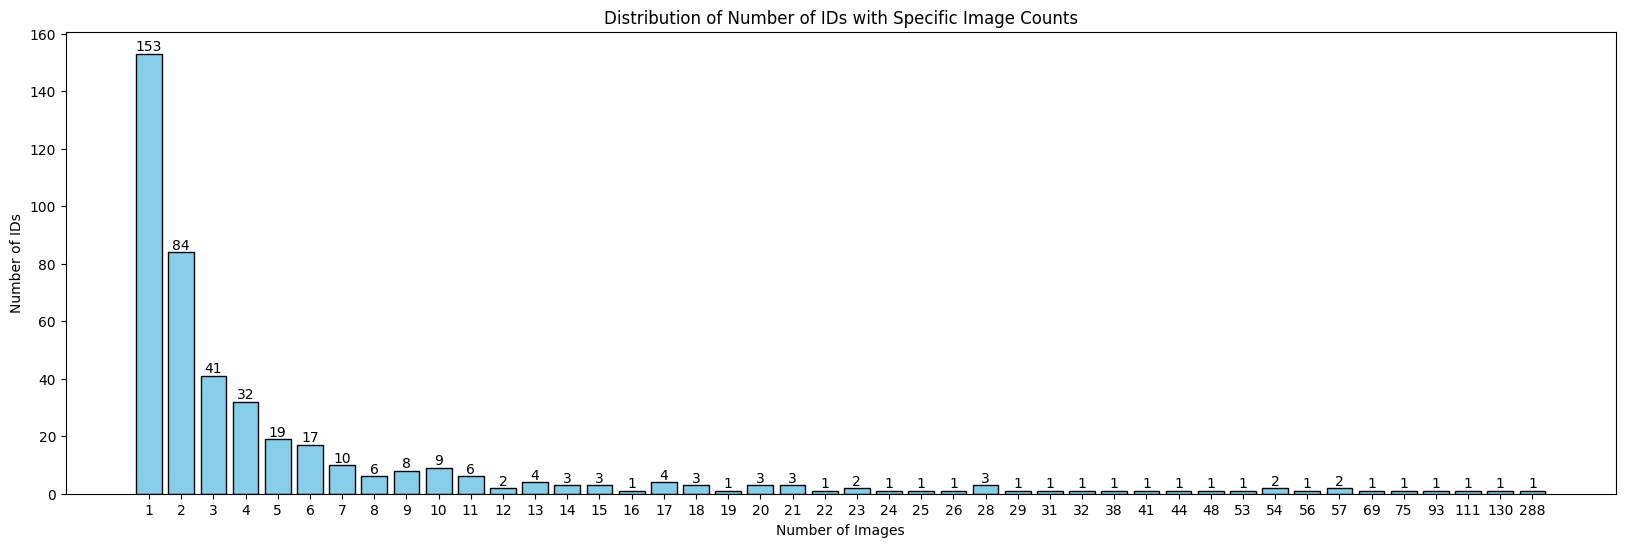

In [6]:
dataset_path = '../3D_Dataset/Albedo'

# Đếm số lượng ảnh cho mỗi ID
id_counts = {}
for id_dir in os.listdir(dataset_path):
    id_path = os.path.join(dataset_path, id_dir)
    if os.path.isdir(id_path):
        num_images = len(os.listdir(id_path))
        id_counts[id_dir] = num_images

# Xếp lại các id.
sorted_keys = sorted(id_counts.keys())

sorted_values = [id_counts[key] for key in sorted_keys]

# Đếm số lượng ID có cùng số lượng ảnh
count_values = Counter(sorted_values)

# Lấy các giá trị duy nhất của số lượng ảnh và số lượng ID tương ứng
unique_values = sorted(count_values.keys())
frequency = [count_values[val] for val in unique_values]

# Chuyển các giá trị trong unique_values thành chuỗi
unique_values_str = list(map(str, unique_values))

# Tính chiều rộng cho mỗi cột
num_row = len(unique_values)  # Số lượng cột
max_value = max(frequency)  # Giá trị lớn nhất trong frequency
width = 0.8  # Chiều rộng cột (giảm xuống để tạo khoảng cách)

# Vẽ biểu đồ cột với chiều rộng tính toán
fig, ax = plt.subplots(figsize=(20, 6))

# Tạo khoảng cách giữa các cột bằng cách tăng khoảng cách giữa chúng (sử dụng range)
bars = ax.bar(unique_values_str, frequency, color='skyblue', edgecolor='black', width=width)

# Thêm số lượng trên mỗi cột
for x, y in zip(unique_values_str, frequency):
    ax.text(x, y, str(y), ha='center', va='bottom', fontsize=10)

# Thêm tiêu đề và nhãn
ax.set_xlabel('Number of Images')
ax.set_ylabel('Number of IDs')
ax.set_title('Distribution of Number of IDs with Specific Image Counts')

# Thiết lập tính năng hiển thị thông tin khi di chuột vào các cột
mplcursors.cursor(bars, hover=True).connect(
    'add', lambda sel: sel.annotation.set_text(f'Number of Images: {sel.target[1]}\nID: {sel.target[0]}')
)

# Hiển thị biểu đồ
plt.show()

Xóa tay folder 1087

In [2]:
import os
import random
import cv2
from concurrent.futures import ProcessPoolExecutor

os.environ["OPENCV_IO_ENABLE_OPENEXR"] = "1"

# Set seed for reproducibility
SEED = 42
random.seed(SEED)

albedo_folder = '../3D_Dataset/Albedo'
depthmap_folder = '../3D_Dataset/Depth_Map'
normalmap_folder = '../3D_Dataset/Normal_Map'

new_albedo_folder = '../Dataset/Albedo'
new_depthmap_folder = '../Dataset/Depth_Map'
new_normalmap_folder = '../Dataset/Normal_Map'

os.makedirs(new_albedo_folder, exist_ok=True)
os.makedirs(new_depthmap_folder, exist_ok=True)
os.makedirs(new_normalmap_folder, exist_ok=True)

num_cpus = 13

# Helper function to seed in subprocesses
def set_seed(seed):
    random.seed(seed)

# Resize and save image
def process_image(src_path, dst_path, target_size=256):
    image = cv2.imread(src_path, cv2.IMREAD_UNCHANGED)

    # interpolation = cv2.INTER_LINEAR
    # if 'depth_map' in src_path.lower() or 'normal_map' in src_path.lower():
    #     interpolation = cv2.INTER_NEAREST

    # resized_image = cv2.resize(image, (target_size, target_size), interpolation=interpolation)
    cv2.imwrite(dst_path, image)

# Undersample and select files
def check(id):
    all_filenames = os.listdir(os.path.join(albedo_folder, id))
    if len(all_filenames) < 3:
        return None, all_filenames
    if len(all_filenames) > 10:
        train_filenames = random.sample(all_filenames, 10)  # Random sampling
    else:
        train_filenames = all_filenames
    return train_filenames, None

# Copy images to the new directory
def copy_to_new_dir(train_filenames, test_filenames, id):
    # Seed each process
    set_seed(SEED)
    
    if train_filenames is not None:
        os.makedirs(os.path.join(new_albedo_folder, 'train', id), exist_ok=True)
        os.makedirs(os.path.join(new_depthmap_folder, 'train', id), exist_ok=True)
        os.makedirs(os.path.join(new_normalmap_folder, 'train', id), exist_ok=True)

        for filename in train_filenames:
            src = os.path.join(albedo_folder, id, filename)
            dist = os.path.join(new_albedo_folder, 'train', id, filename)
            process_image(src, dist)

            src = os.path.join(depthmap_folder, id, filename)
            dist = os.path.join(new_depthmap_folder, 'train', id, filename)
            process_image(src, dist)

            src = os.path.join(normalmap_folder, id, filename)
            dist = os.path.join(new_normalmap_folder, 'train', id, filename)
            process_image(src, dist)

    if test_filenames is not None:
        os.makedirs(os.path.join(new_albedo_folder, 'test', id), exist_ok=True)
        os.makedirs(os.path.join(new_depthmap_folder, 'test', id), exist_ok=True)
        os.makedirs(os.path.join(new_normalmap_folder, 'test', id), exist_ok=True)

        for filename in test_filenames:
            src = os.path.join(albedo_folder, id, filename)
            dist = os.path.join(new_albedo_folder, 'test', id, filename)
            process_image(src, dist)

            src = os.path.join(depthmap_folder, id, filename)
            dist = os.path.join(new_depthmap_folder, 'test', id, filename)
            process_image(src, dist)

            src = os.path.join(normalmap_folder, id, filename)
            dist = os.path.join(new_normalmap_folder, 'test', id, filename)
            process_image(src, dist)

# Parallel processing with consistent seeding
with ProcessPoolExecutor(max_workers=num_cpus) as executor:
    for id in os.listdir(albedo_folder):
        train_filenames, test_filenames = check(id)
        executor.submit(copy_to_new_dir, train_filenames, test_filenames, id)

**Sample dataset**

In [1]:
import os
import random
import cv2
from concurrent.futures import ProcessPoolExecutor

os.environ["OPENCV_IO_ENABLE_OPENEXR"] = "1"

# Set seed for reproducibility
SEED = 42
random.seed(SEED)

albedo_folder = '../3D_Dataset/Albedo'
depthmap_folder = '../3D_Dataset/Depth_Map'
normalmap_folder = '../3D_Dataset/Normal_Map'

new_albedo_folder = '../Sample_Dataset/Albedo'
new_depthmap_folder = '../Sample_Dataset/Depth_Map'
new_normalmap_folder = '../Sample_Dataset/Normal_Map'

os.makedirs(new_albedo_folder, exist_ok=True)
os.makedirs(new_depthmap_folder, exist_ok=True)
os.makedirs(new_normalmap_folder, exist_ok=True)

num_cpus = 13

# Helper function to seed in subprocesses
def set_seed(seed):
    random.seed(seed)

# Resize and save image
def process_image(src_path, dst_path, target_size=256):
    image = cv2.imread(src_path, cv2.IMREAD_UNCHANGED)

    # interpolation = cv2.INTER_LINEAR
    # if 'depth_map' in src_path.lower() or 'normal_map' in src_path.lower():
        # interpolation = cv2.INTER_NEAREST

    # resized_image = cv2.resize(image, (target_size, target_size), interpolation=interpolation)
    # cv2.imwrite(dst_path, resized_image)
    cv2.imwrite(dst_path, image)

# Undersample and select files
def check(id):
    all_filenames = os.listdir(os.path.join(albedo_folder, id))
    if len(all_filenames) < 3:
        return None, all_filenames
    else:
        return all_filenames, None

# Copy images to the new directory
def copy_to_new_dir(train_filenames, test_filenames, id):
    # Seed each process
    set_seed(SEED)
    
    if train_filenames is not None:
        os.makedirs(os.path.join(new_albedo_folder, 'train', id), exist_ok=True)
        os.makedirs(os.path.join(new_depthmap_folder, 'train', id), exist_ok=True)
        os.makedirs(os.path.join(new_normalmap_folder, 'train', id), exist_ok=True)

        for filename in train_filenames:
            src = os.path.join(albedo_folder, id, filename)
            dist = os.path.join(new_albedo_folder, 'train', id, filename)
            process_image(src, dist)

            src = os.path.join(depthmap_folder, id, filename)
            dist = os.path.join(new_depthmap_folder, 'train', id, filename)
            process_image(src, dist)

            src = os.path.join(normalmap_folder, id, filename)
            dist = os.path.join(new_normalmap_folder, 'train', id, filename)
            process_image(src, dist)

    if test_filenames is not None:
        os.makedirs(os.path.join(new_albedo_folder, 'test', id), exist_ok=True)
        os.makedirs(os.path.join(new_depthmap_folder, 'test', id), exist_ok=True)
        os.makedirs(os.path.join(new_normalmap_folder, 'test', id), exist_ok=True)

        for filename in test_filenames:
            src = os.path.join(albedo_folder, id, filename)
            dist = os.path.join(new_albedo_folder, 'test', id, filename)
            process_image(src, dist)

            src = os.path.join(depthmap_folder, id, filename)
            dist = os.path.join(new_depthmap_folder, 'test', id, filename)
            process_image(src, dist)

            src = os.path.join(normalmap_folder, id, filename)
            dist = os.path.join(new_normalmap_folder, 'test', id, filename)
            process_image(src, dist)

# Parallel processing with consistent seeding
with ProcessPoolExecutor(max_workers=num_cpus) as executor:
    for id in os.listdir(albedo_folder):
        train_filenames, test_filenames = check(id)
        executor.submit(copy_to_new_dir, train_filenames, test_filenames, id)

KeyboardInterrupt: 

[ERROR:0@24.580] global loadsave.cpp:787 imwrite_ imwrite_('../Sample_Dataset/Normal_Map/test/1176/2007-12-06_14-50-46.exr'): can't write data: unknown exception
[ERROR:0@24.590] global loadsave.cpp:787 imwrite_ imwrite_('../Sample_Dataset/Albedo/train/1066/2008-03-19_13-24-20.exr'): can't write data: unknown exception
[ERROR:0@24.597] global loadsave.cpp:787 imwrite_ imwrite_('../Sample_Dataset/Normal_Map/train/1174/2007-12-04_17-50-54.exr'): can't write data: unknown exception
[ERROR:0@24.598] global loadsave.cpp:787 imwrite_ imwrite_('../Sample_Dataset/Albedo/train/1043/2008-02-18_10-52-44.exr'): can't write data: unknown exception
[ERROR:0@24.602] global loadsave.cpp:787 imwrite_ imwrite_('../Sample_Dataset/Depth_Map/train/1066/2008-03-19_13-24-20.exr'): can't write data: unknown exception
[ERROR:0@24.606] global loadsave.cpp:787 imwrite_ imwrite_('../Sample_Dataset/Albedo/train/1174/2007-12-04_17-52-56.exr'): can't write data: unknown exception
[ERROR:0@24.618] global loadsave.cpp

### Check shape

In [ ]:
# Đường dẫn dataset
dataset_path = "../Dataset_256/Albedo/train"

# Thu thập thông tin shape
shapes = []

for root, dirs, files in os.walk(dataset_path):
    for file in files:
        file_path = os.path.join(root, file)
        img = cv2.imread(file_path, cv2.IMREAD_UNCHANGED)
        shapes.append(img.shape)

# Tách chiều rộng và chiều cao
heights, widths = zip(*shapes)

# 1. Trực quan hóa phân bố chiều rộng và chiều cao
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.histplot(widths, kde=True, color="blue", bins=30)
plt.title("Distribution of Widths")
plt.xlabel("Width")
plt.ylabel("Frequency")

plt.subplot(1, 2, 2)
sns.histplot(heights, kde=True, color="green", bins=30)
plt.title("Distribution of Heights")
plt.xlabel("Height")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

# 2. Biểu đồ scatter chiều rộng và chiều cao
plt.figure(figsize=(8, 6))
plt.scatter(widths, heights, alpha=0.5, c="orange")
plt.title("Scatter Plot of Image Dimensions")
plt.xlabel("Width")
plt.ylabel("Height")
plt.grid(True)
plt.show()

# Summary

Trong notebook này, em đã thực hiện:

0. Hiểu dữ liệu 
1. Gen các ảnh chứa thông tin 3D như normal map, depth map và albedo bằng phương pháp photometric streo.
2. Thực hiện face aligment bằng cách sử dụng mtcnn để detect face trong image và adjust lại box của mtcnn sao cho ảnh có kích thước (448, 336) và điểu chỉnh ảnh crop sao cho phù hợp, scale up nếu ảnh ban đầu không đủ kích thước và sử dụng các phép nội suy thích hợp để suy diễn các pixel còn thiếu.
    - Có 3 session mtcnn không detect được và 1 trường hợp khó thuật toán của em detect lỗi. Các trường hợp này phải thực hiện crop lại bằng tay
    - Có 13 session cho ảnh bị lỗi albedo, normal map, depth map. Ảnh quá tối, che khuất quá nhiều, ... và phải bỏ
    - Kích thước toàn dataset giảm mạnh từ 100 GB về 9,2GB dữ liệu 3D. Trong đó dữ liệu albedo và depthmap là 1,9 GB còn dữ liệu normal map là chứa 9,5 GB
3. Chia tập dữ liệu thành train và test với tỷ lệ 8:2
4. Bước tiếp theo em sẽ thực hiện train 3 mạng neutron để tạo ra các embedding tương ứng của 3 loại dữ liệu 3D.
    - Train 1 model có khả năng trích xuất embedding chứa thông tin danh tính của normal map. Emdedding này cung cấp thông tin danh tính về hình dạng bề mặt của mặt người như độ gồ ghề, lồi lõm, pose, ... mà ảnh 2D không thể hiện được.
    - Train 1 model có khả năng trích xuất embedding chứa thông tin danh tính của depth map. Emdedding này cung cấp thông tin danh tính về hình dạng không gian và độ sâu các điểm trên bề mặt mặt người.
    - Train 1 model có khả năng trích xuất embedding chứa thông tin danh tính của albedo.Emdedding này cung cấp thông tin danh tính về độ phản chiếu ánh sáng hay màu sắc, kết cấu và đặc trưng vật liệu của từng điểm trên khuôn mặt. Nó không bị ảnh hưởng bởi ánh sáng.
    - Cuối cùng sẽ là 1 model để fusion các embedding trên. Sau cùng mạng neutron thu được có khả năng dung hòa những lợi ích mà các embedding trên có thể mang lại. Model sẽ có khả năng nhận diện được hình dạng bề mặt, pose, không bị ảnh hưởng bởi hướng chiếu sáng, ... mà những model 2D truyền thống không thể xử lý, trích xuất được. Từ đó cho ra hiệu suất Face Recognition tốt hơn.
    - Bước này em sẽ thực hiện những công nghệ tốt nhất dựa theo research : https://arxiv.org/pdf/2212.13038